<a href="https://colab.research.google.com/github/IvanNece/LABS_Edge-Computing-Systems-for-AI-and-ML/blob/main/Lab_0/3_WineQualityClassifier/WineQualityClassifierRFC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Random Forest Wine Quality Classifier with scikit-learn

To begin, let's import **numpy**, which provides support for more efficient numerical computation, and **pandas**, a convenient library that supports dataframes. Pandas is technically optional because Scikit-Learn can handle numerical matrices directly, but it'll make our lives easier:

In [29]:
import numpy as np
import pandas as pd

Now it's time to start importing functions for machine learning. The first one will be the train_test_split() function from the model_selection module. As its name implies, this module contains many utilities that will help us choose between models. Next, we'll import the entire preprocessing module. This contains utilities for scaling, transforming, and wrangling data.

In [30]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

Next, let's import the **families** of models we'll need. What's the difference between model "families" and actual models?  A "family" of models are broad types of models, such as random forests, SVM's, linear regression models, etc. Within each family of models, you'll get an actual model after you fit and tune its parameters to the data.

We can import the random forest family like so:

In [31]:
from sklearn.ensemble import RandomForestClassifier

For now, let's move on to importing the tools to help us perform cross-validation.

In [32]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

Next, let's import some metrics we can use to evaluate our model performance later.

In [33]:
from sklearn.metrics import mean_squared_error, r2_score

And finally, we'll import a way to save our model for future use. Joblib is an alternative to Python's pickle package, and we'll use it because it's more efficient for storing large numpy arrays.

In [34]:
import joblib

Now we're ready to load our data set. The Pandas library help us read data from CSV, Excel, SQL, SAS, and many other data formats.

The convenient tool we'll use today is the read_csv() function. Using this function, we can load any CSV file, even from a remote URL. We load the red wine dataset and print the first 5 rows of data and some relevant statistics:

In [35]:
dataset_red_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
#dataset_white_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv'
data = pd.read_csv(dataset_red_url,sep=";")
print(data.head())
print(data.shape)
print(data.describe())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

Here's the list of all the features:
*    quality (**target**)
*    fixed acidity
*    volatile acidity
*    citric acid
*    residual sugar
*    chlorides
*    free sulfur dioxide
*    total sulfur dioxide
*    density
*    pH
*    sulphates
*    alcohol

All of the features are numeric, which is convenient. However, they have some very different scales, so let's make a mental note to standardize the data later.

For now, let's move on to splitting the data. Splitting the data into training and test sets at the beginning of your modeling workflow is crucial for getting a realistic estimate of your model's performance.

First, let's separate our target (y) features from our input (X) features. Then we use the **train_test_split** function to separate the **training** set (80% in this case) from the **test** set (20%). We also use a random seed to perform the splitting and apply "stratification." In this context, stratification means that the train_test_split method returns training and test subsets that have the same proportions of class labels as the input dataset.

In [36]:
y = data.quality
X = data.drop('quality', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=123,
                                                    stratify=y)

Now it's time to perform standardization.

Standardization is the process of subtracting the means from each feature and then dividing by the feature standard deviations.

Standardization is a common requirement for machine learning tasks. Many algorithms assume that all features are centered around zero and have approximately the same variance.

We use a feature in Scikit-Learn called the Transformer API (not to be confused with Transformer networks for Natural Language Processing). The Transformer API allows you to "fit" a preprocessing step using the training data the same way you'd fit a model and then use the same transformation on future data sets!

Here's what that process looks like:

*    Fit the transformer on the training set (saving the means and standard deviations)
*    Apply the transformer to the training set (scaling the training data)
*    Apply the transformer to the test set (using the same means and standard deviations)

This makes your final estimate of model performance more realistic, and it allows to insert your preprocessing steps into a cross-validation pipeline.

Here's how you do it:

In [37]:
scaler = preprocessing.StandardScaler().fit(X_train)

Now, the scaler object has the saved means and standard deviations for each feature in the training set.

Let's confirm that worked:

In [38]:
X_train_scaled = scaler.transform(X_train)
print(X_train_scaled.mean(axis=0))
# [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
print(X_train_scaled.std(axis=0))
# [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]

[ 1.16664562e-16 -3.05550043e-17 -8.47206937e-17 -2.22218213e-17
  2.77772766e-18 -6.38877362e-17 -4.16659149e-18 -1.20753377e-13
 -8.70817622e-16 -4.08325966e-16 -1.16664562e-15]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


Notice that the mean isn't exactly zero, but yet very small.

Note how we're taking the scaler object and using it to transform the training set. We can transform the test set using the exact same means and standard deviations used to transform the training set. Notice how the scaled features in the test set are not perfectly centered at zero with unit variance!

In [39]:
X_test_scaled = scaler.transform(X_test)

print(X_test_scaled.mean(axis=0))
# [ 0.02776704  0.02592492 -0.03078587 -0.03137977 -0.00471876 -0.04413827
#  -0.02414174 -0.00293273 -0.00467444 -0.10894663  0.01043391]

print(X_test_scaled.std(axis=0))
# [ 1.02160495  1.00135689  0.97456598  0.91099054  0.86716698  0.94193125
#  1.03673213  1.03145119  0.95734849  0.83829505  1.0286218 ]

[ 0.02776704  0.02592492 -0.03078587 -0.03137977 -0.00471876 -0.04413827
 -0.02414174 -0.00293273 -0.00467444 -0.10894663  0.01043391]
[1.02160495 1.00135689 0.97456598 0.91099054 0.86716698 0.94193125
 1.03673213 1.03145119 0.95734849 0.83829505 1.0286218 ]


This is exactly what we'd expect, as we're transforming the test set using the means from the training set, not from the test set itself.

In practice, when we set up the cross-validation pipeline, we won't even need to manually fit the Transformer API. Instead, we'll simply declare the class object, like this:

In [40]:
pipeline = make_pipeline(preprocessing.StandardScaler(),
                         RandomForestClassifier(n_estimators=100))

This is exactly what it looks like: a modeling pipeline that first transforms the data using StandardScaler() and then fits a model using a random forest classifier. The number of trees in the forest is given by the parameter "n_estimator", which in this case is set to 100 (this is also the default value).


Now it's time to consider the **hyperparameters** that we'll want to tune for our model. There are two types of parameters we need to worry about: model parameters and hyperparameters. Models parameters can be learned directly from the data (i.e. regression coefficients), while hyperparameters cannot.

Hyperparameters express "higher-level" structural information about the model, and they are typically set before training the model.

As an example, let's take our random forest for classification:

Within each decision tree, the computer can empirically decide where to create branches based on either mean-squared-error (MSE) or mean-absolute-error (MAE). Therefore, the actual branch locations are model parameters.

However, the algorithm does not know which of the two criteria, MSE or MAE, that it should use. The algorithm also cannot decide how many trees to include in the forest. These are examples of hyperparameters that the user must set.

We can list the tunable hyperparameters like so:

In [41]:
print(pipeline.get_params())

{'memory': None, 'steps': [('standardscaler', StandardScaler()), ('randomforestclassifier', RandomForestClassifier())], 'transform_input': None, 'verbose': False, 'standardscaler': StandardScaler(), 'randomforestclassifier': RandomForestClassifier(), 'standardscaler__copy': True, 'standardscaler__with_mean': True, 'standardscaler__with_std': True, 'randomforestclassifier__bootstrap': True, 'randomforestclassifier__ccp_alpha': 0.0, 'randomforestclassifier__class_weight': None, 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': None, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_leaf_nodes': None, 'randomforestclassifier__max_samples': None, 'randomforestclassifier__min_impurity_decrease': 0.0, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__min_weight_fraction_leaf': 0.0, 'randomforestclassifier__monotonic_cst': None, 'randomforestclassifier__n_estimators

The meaning of all the hyperparameters and the options for their values can be found on the [Random Forest Classifier documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). Here we focus only on those hyperparameters that we want to tune through cross-validation:

In [42]:
hyperparameters = { 'randomforestclassifier__max_features' : ['sqrt', 'log2', None],
                  'randomforestclassifier__max_depth': [None, 5, 3, 1]}

We selected the "max_features" and "max_depth" parameters.

The first one represents the number of features to consider when looking for the best split:

*    If “auto” or “sqrt”, then max_features=sqrt(n_features).
*    If “log2”, then max_features=log2(n_features).
*    If None, then max_features=n_features.

The second one is the maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than "min_samples_split" (default is 2) samples.


As you can see, we define the subset of hyperparameters as a Python dictionary (data structure for key-value pairs) where keys are the hyperparameter names and values are lists of settings to try.

Now we're almost ready to dive into fitting our models. But first, we need to spend some time talking about **cross-validation**.

This is one of the most important skills in all of machine learning because it helps you maximize model performance while reducing the chance of **overfitting**.

Cross-validation is a process for reliably estimating the performance of a method for building a model by training and evaluating your model multiple times using the same method.

Practically, that "method" is simply a set of hyperparameters in this context.

These are the steps for CV:

1.    Split your data into k equal parts, or "folds" (typically k=10).
2.    Train your model on k-1 folds (e.g. the first 9 folds).
3.    Evaluate it on the remaining "hold-out" fold (e.g. the 10th fold).
4.    Perform steps (2) and (3) k times, each time holding out a different fold.
5.    Aggregate the performance across all k folds. This is your performance metric.

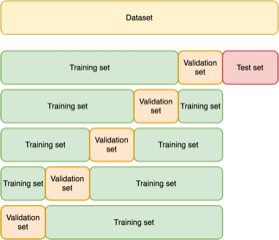

<!--Notice how the held-out set is called "Test data" in the picture above, whereas in class this set was called "validation" data. Unfortunately, there are still ambiguities in the way things are defined in this field. We should just be aware and live with it.-->
In the picture above, CV is done in k=5 steps.

The best practice when performing CV is to include your data preprocessing steps inside the cross-validation loop. This prevents accidentally tainting your training folds with influential data from your test fold.

Here's how the CV pipeline looks after including preprocessing steps:

1.    Split your data into **k** equal parts, or "folds" (typically k=10).
2.    Preprocess **k-1** training folds.
3.    Train your model on the same **k-1** folds.
4.    Preprocess the hold-out fold using the same transformations from step (2).
5.    Evaluate your model on the same hold-out fold.
6.    Perform steps (2) - (5) **k** times, each time holding out a different fold.
7.    Aggregate the performance across all **k** folds. This is your performance metric.

Fortunately, Scikit-Learn makes it as simple as it can get:



In [43]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# FIX: usa un numero di fold compatibile con la classe più rara (qui 4)
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=123)

clf = GridSearchCV(
    estimator=pipeline,
    param_grid=hyperparameters,
    cv=cv,
    n_jobs=-1
)

clf.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=123, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': [None, 5, 3, 1],
                         'randomforestclassifier__max_features': ['sqrt',
                                                                  'log2',
                                                                  None]})

**GridSearchCV** essentially performs cross-validation across the entire "grid" (all possible permutations) of hyperparameters.

It takes in your model (in this case, we're using a model pipeline), the hyperparameters you want to tune, and the number of folds to create.

Obviously, there's a lot going on under the hood, but we will not cover the details in the interest of time.

Now, you can see the best set of parameters found using CV:

In [44]:
print(clf.best_params_)

{'randomforestclassifier__max_depth': None, 'randomforestclassifier__max_features': 'sqrt'}


After you've tuned your hyperparameters appropriately using cross-validation, you can generally get a small performance improvement by refitting the model on the entire training set.

Conveniently, GridSearchCV from sklearn will automatically refit the model with the best set of hyperparameters using the entire training set.

This functionality is ON by default, but you can confirm it:

In [45]:
print(clf.refit)
# True

True


Now, you can simply use the  clf object as your model when applying it to other sets of data. That's what we'll be doing in the next step.

This step is really straightforward once you understand that the clf object you used to tune the hyperparameters can also be used directly like a model object.

Here's how to predict a new set of data:

In [46]:
y_pred = clf.predict(X_test)

Now we can use the metrics we imported earlier to evaluate our model performance.

In [47]:
print(r2_score(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))

0.37526484654034764
0.403125


In [48]:
y_pred_train = clf.predict(X_train)
print(r2_score(y_train, y_pred_train))
print(mean_squared_error(y_train, y_pred_train))

1.0
0.0


Great, so now the question is... is this performance good enough?

Well, the rule of thumb is that your very first model probably won't be the best possible model. However, we recommend a combination of three strategies to decide if you're satisfied with your model performance.

1.    Start with the goal of the model. If the model is tied to a business problem, have you successfully solved the problem?
2.    Look in academic literature to get a sense of the current performance benchmarks for specific types of data.
3.    Try to find low-hanging fruit in terms of ways to improve your model.

There are various ways to improve a model. We'll have more guides that go into detail about how to improve model performance, but here are a few quick things to try:

1.    Try other regression model families (e.g. regularized regression, boosted trees, etc.).
2.    Collect more data if it's cheap to do so.
3.    Engineer smarter features after spending more time on exploratory analysis.
4.    Speak to a domain expert to get more context (...this is a good excuse to go wine tasting!).

As a final note, when you try other families of models, we recommend using the same training and test set as you used to fit the random forest model. That's the best way to get a true apples-to-apples comparison between your models.

Before you go, let's save your hard work so you can use the model in the future. It's really easy to do so:

In [49]:
joblib.dump(clf, 'rf_regressor.pkl')

['rf_regressor.pkl']

And that's it. When you want to load the model again, simply use this function:

In [50]:
clf2 = joblib.load('rf_regressor.pkl')

# Predict data set using loaded model
clf2.predict(X_test)

array([7, 6, 5, 6, 6, 6, 5, 5, 5, 6, 5, 6, 6, 5, 6, 6, 6, 6, 6, 7, 5, 6,
       5, 6, 6, 5, 5, 5, 6, 6, 6, 6, 6, 5, 5, 6, 5, 6, 5, 6, 5, 6, 7, 5,
       6, 5, 5, 5, 5, 7, 6, 5, 6, 5, 6, 6, 5, 5, 5, 5, 5, 5, 5, 6, 6, 5,
       6, 5, 5, 7, 6, 6, 5, 5, 5, 6, 5, 5, 5, 5, 6, 6, 6, 6, 5, 5, 7, 6,
       6, 5, 6, 5, 7, 6, 6, 6, 7, 7, 5, 7, 5, 5, 5, 6, 5, 5, 6, 5, 6, 6,
       6, 5, 6, 5, 5, 5, 6, 5, 5, 6, 6, 5, 6, 6, 5, 5, 6, 6, 5, 5, 5, 7,
       5, 5, 5, 7, 5, 5, 7, 5, 5, 5, 6, 6, 5, 5, 5, 6, 6, 5, 6, 5, 5, 5,
       5, 6, 5, 6, 6, 5, 6, 5, 5, 6, 5, 6, 5, 6, 6, 5, 6, 5, 6, 5, 6, 5,
       5, 5, 6, 5, 6, 5, 5, 5, 5, 6, 5, 6, 5, 5, 5, 7, 6, 6, 5, 5, 5, 5,
       6, 5, 6, 5, 5, 5, 7, 6, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 5, 5, 6, 5,
       5, 6, 6, 5, 6, 6, 6, 6, 5, 6, 5, 6, 6, 6, 5, 5, 7, 6, 6, 5, 6, 6,
       5, 6, 6, 5, 5, 5, 5, 6, 5, 5, 5, 5, 6, 7, 6, 5, 5, 7, 5, 6, 5, 5,
       6, 6, 6, 6, 5, 5, 6, 5, 7, 6, 5, 5, 6, 7, 6, 5, 6, 5, 5, 6, 7, 5,
       7, 5, 5, 5, 6, 5, 5, 6, 6, 6, 6, 6, 5, 6, 6,

Now let's plot the confusion matrix

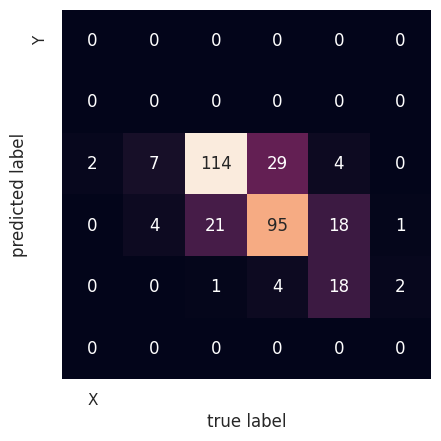

In [51]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()
from sklearn.metrics import confusion_matrix
y_int = [int(i) for i in y_pred]
mat = confusion_matrix(y_test, y_int)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels="X",
            yticklabels="Y")
plt.xlabel('true label')
plt.ylabel('predicted label');